In [1]:
%matplotlib inline
import pylab
import os
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from SensorimotorExploration.DataManager.SimulationData import load_sim_h5
from SensorimotorExploration.DataManager.PlotTools import *

In [3]:
def create_dict(groups_k):
    return {k[0] + '_' + k[1]: [] for k in groups_k}


def incremental_mean(arr_):
    n_samples = len(arr_)
    return [sum(arr_[:x]) / (x + 1) for x in range(n_samples)]


In [18]:
directory = 'experiment_9_ins04/'
data_files = os.listdir(directory)

# Group by:
type_ops = ['proprio', 'simple']
mode_ops = ['autonomous', 'social']

groups_k = list(itertools.product(type_ops, mode_ops))

means_s = create_dict(groups_k)
means_av_s = create_dict(groups_k)

means_w = create_dict(groups_k)
means_av_w = create_dict(groups_k)

coll_s = create_dict(groups_k)
coll_av_s = create_dict(groups_k)

coll_w = create_dict(groups_k)
coll_av_w = create_dict(groups_k)

inter = create_dict(groups_k)
inter_av = create_dict(groups_k)

error_ev = create_dict(groups_k)
error_ev_av = create_dict(groups_k)

for data_file in (d_f for d_f in data_files if 'sim_data.h5' in d_f):
    data_file = directory + data_file
    conf_file = data_file.replace('sim_data.h5', 'conf.txt')
    conf = {}
    with open(conf_file) as f:
        for line in f:
            line = line.replace('\n', '')
            (key, val) = line.split(': ')
            conf[key] = val

    try:
        data = load_sim_h5(data_file)
        interaction_data = data.social.data.as_matrix(columns=None)
        interactions = np.zeros((interaction_data.shape[0],))
        interactions[~np.isnan(interaction_data[:, 0])] = 1

        social_data = load_sim_h5(data_file.replace('sim_data.h5', 'social_eva_valset.h5'))
        whole_data = load_sim_h5(data_file.replace('sim_data.h5', 'whole_eva_valset.h5'))

        s_error_ = np.linalg.norm(social_data.sensor_goal.data.as_matrix() -
                                  social_data.sensor.data.as_matrix(), axis=1)

        s_con_v = social_data.somato.data.as_matrix()

        w_error_ = np.linalg.norm(whole_data.sensor_goal.data.as_matrix() -
                                  whole_data.sensor.data.as_matrix(), axis=1)

        w_con_v = whole_data.somato.data.as_matrix()

        eva_errors = []
        with open(data_file.replace('sim_data.h5', 'eval_error.txt'), 'r') as f:
            for line in f:
                line.replace('\n', '')
                eva_errors_str = line.split(': ')
                eva_errors += [float(eva_errors_str[1])]

        means_s[conf['type'] + '_' + conf['mode']] += [np.mean(s_error_)]
        means_w[conf['type'] + '_' + conf['mode']] += [np.mean(w_error_)]

        coll_s[conf['type'] + '_' + conf['mode']] += [s_con_v]
        coll_w[conf['type'] + '_' + conf['mode']] += [w_con_v]

        inter[conf['type'] + '_' + conf['mode']] += [interactions]

        error_ev[conf['type'] + '_' + conf['mode']] += [eva_errors]

    except IOError:
        pass

legend = []
for i, k in enumerate(groups_k):
    group = k[0] + '_' + k[1]
    legend += [group]

    means_av_s[group] = np.mean(np.array(means_s[group]))
    means_av_w[group] = np.mean(np.array(means_w[group]))

    coll_av_s[group] = np.mean(np.array(coll_s[group]), axis=0)
    coll_av_w[group] = np.mean(np.array(coll_w[group]), axis=0)

    inter_av[group] = np.mean(np.array(inter[group]), axis=0)

    error_ev_av[group] = np.mean(np.array(error_ev[group]), axis=0)

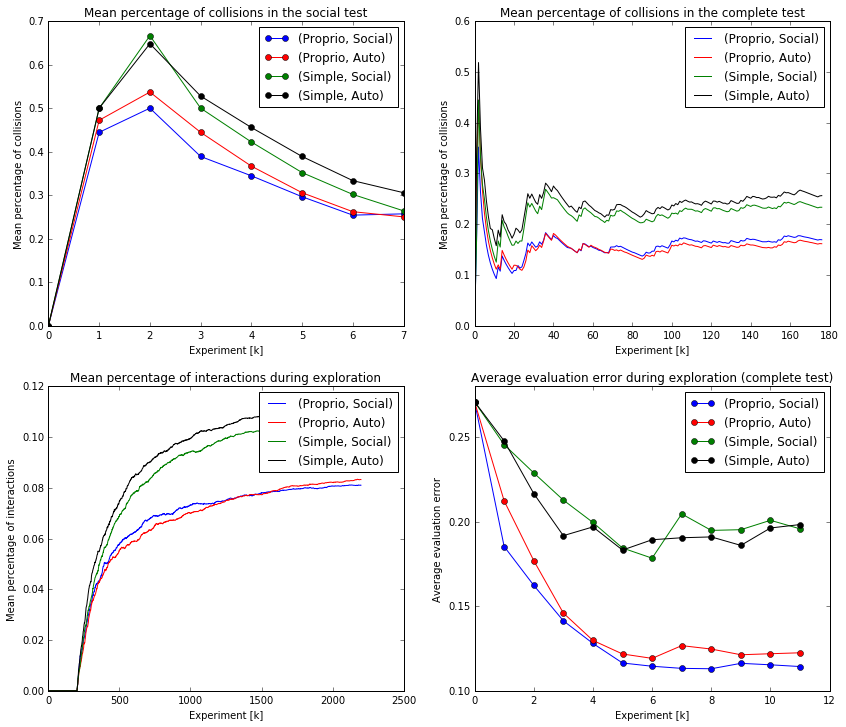

In [19]:
pylab.rcParams['figure.figsize'] = (14.0, 12.0)
fig1, ax1 = plt.subplots(2,2)
plt.sca(ax1[0,0])
ax1[0,0].set_title('Mean percentage of collisions in the social test')
plt.plot(incremental_mean(coll_av_s['proprio_social']), linestyle='-', marker='o', color='b')
plt.hold(True)
plt.plot(incremental_mean(coll_av_s['proprio_autonomous']), linestyle='-', marker='o', color='r')
plt.plot(incremental_mean(coll_av_s['simple_social']), linestyle='-', marker='o', color='g')
plt.plot(incremental_mean(coll_av_s['simple_autonomous']), linestyle='-', marker='o', color='k')
plt.xlabel('Experiment [k]')
plt.ylabel('Mean percentage of collisions')
plt.legend(['(Proprio, Social)', '(Proprio, Auto)', '(Simple, Social)', '(Simple, Auto)'])

plt.sca(ax1[0,1])
ax1[0,1].set_title('Mean percentage of collisions in the complete test')
plt.plot(incremental_mean(coll_av_w['proprio_social']), linestyle='-', marker='', color='b')
plt.hold(True)
plt.plot(incremental_mean(coll_av_w['proprio_autonomous']), linestyle='-', marker='', color='r')
plt.plot(incremental_mean(coll_av_w['simple_social']), linestyle='-', marker='', color='g')
plt.plot(incremental_mean(coll_av_w['simple_autonomous']), linestyle='-', marker='', color='k')
plt.xlabel('Experiment [k]')
plt.ylabel('Mean percentage of collisions')
plt.legend(['(Proprio, Social)', '(Proprio, Auto)', '(Simple, Social)', '(Simple, Auto)'])

plt.sca(ax1[1,0])
ax1[1,0].set_title('Mean percentage of interactions during exploration')
plt.plot(incremental_mean(inter_av['proprio_social']), linestyle='-', marker='', color='b')
plt.hold(True)
plt.plot(incremental_mean(inter_av['proprio_autonomous']), linestyle='-', marker='', color='r')
plt.plot(incremental_mean(inter_av['simple_social']), linestyle='-', marker='', color='g')
plt.plot(incremental_mean(inter_av['simple_autonomous']), linestyle='-', marker='', color='k')
plt.xlabel('Experiment [k]')
plt.ylabel('Mean percentage of interactions')
plt.legend(['(Proprio, Social)', '(Proprio, Auto)', '(Simple, Social)', '(Simple, Auto)'])

plt.sca(ax1[1,1])
ax1[1,1].set_title('Average evaluation error during exploration (complete test)')
plt.plot(error_ev_av['proprio_social'], linestyle='-', marker='o', color='b')
plt.hold(True)
plt.plot(error_ev_av['proprio_autonomous'], linestyle='-', marker='o', color='r')
plt.plot(error_ev_av['simple_social'], linestyle='-', marker='o', color='g')
plt.plot(error_ev_av['simple_autonomous'], linestyle='-', marker='o', color='k')
plt.xlabel('Experiment [k]')
plt.ylabel('Average evaluation error')
plt.legend(['(Proprio, Social)', '(Proprio, Auto)', '(Simple, Social)', '(Simple, Auto)'])

plt.show()

In [20]:
print(means_av_s)

{'proprio_social': 0.22663642999490896, 'simple_autonomous': 0.28548210789415868, 'proprio_autonomous': 0.20958574317960832, 'simple_social': 0.25804431679763984}


In [21]:
print(means_av_w)

{'proprio_social': 0.11434433287245398, 'simple_autonomous': 0.19831103794170912, 'proprio_autonomous': 0.12248343990193887, 'simple_social': 0.19578749737302356}
